In [53]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torch.optim as optim
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Net(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc_block = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.fc_block(x)

        return x

    def general_step(self, batch, batch_idx):
        images, targets = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, targets)

        preds = out.argmax(axis=1)
        acc = (targets == preds).float().mean()
        
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.general_step(batch, batch_idx)
        logs = {'train_loss': loss, 'training_acc': acc}
        return {'loss': loss, 'training_acc': acc, 'log': logs}

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        loss, acc = self.general_step(batch, batch_idx)
        logs = {'val_loss': loss, 'val_acc': acc}
        return {'val_loss': loss, 'val_acc': acc, 'log': logs}

    def validation_end(self, outputs):
        # average over all batches aggregated during one epoch
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).sum()
        avg_acc /= len(outputs)
        logs = {'val_loss': avg_loss, 'val_acc': avg_acc}
        return {'val_loss': avg_loss, 'log': logs}
    
    def test_step(self, batch, batch_idx):
        loss, acc = self.general_step(batch, batch_idx)
        return {'test_loss': loss, 'test_acc': acc}

    def configure_optimizers(self):
        opt = optim.SGD(self.parameters(), lr=self.hparams["learning_rate"], momentum=0.9)
        return opt

    def prepare_data(self):
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

        train_set, val_set = random_split(cifar10_train, [40000, 10000])
        self.train_set = train_set
        self.val_set = val_set
        self.test_set = cifar10_test

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.hparams["batch_size"], shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.hparams["batch_size"])

    def test_dataloader(self):
        return DataLoader(self.test_set)

In [3]:
hparams = {
    "batch_size": 64,
    "learning_rate": 1e-3
}

In [4]:
model = Net(hparams)
trainer_1 = pl.Trainer(profiler=True, max_epochs=30, gpus=1)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


In [5]:
trainer_1.fit(model)

c:\users\thien\.virtualenvs\i2dl-a4dtsivt\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
c:\users\thien\.virtualenvs\i2dl-a4dtsivt\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)


Files already downloaded and verified
Files already downloaded and verified



  | Name       | Type       | Params
--------------------------------------
0 | conv1      | Conv2d     | 456   
1 | pool       | MaxPool2d  | 0     
2 | conv2      | Conv2d     | 2 K   
3 | fc_block   | Sequential | 59 K  
4 | fc_block.0 | Linear     | 48 K  
5 | fc_block.1 | ReLU       | 0     
6 | fc_block.2 | Linear     | 10 K  
7 | fc_block.3 | ReLU       | 0     
8 | fc_block.4 | Linear     | 850   




Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_train_start      	|  0.015          	|  0.015          
on_epoch_start      	|  0.0010667      	|  0.032          
get_train_batch     	|  0.014289       	|  268.35         
on_batch_start      	|  1.4987e-05     	|  0.281          
model_forward       	|  0.0028097      	|  52.681         
model_backward      	|  0.0027722      	|  51.979         
on_after_backward   	|  1.7067e-06     	|  0.032          
optimizer_step      	|  0.0020118      	|  37.721         
on_batch_end        	|  0.0014807      	|  27.764         
on_epoch_end        	|  0.0            	|  0.0            
on_train_end        	|  0.0            	|  0.0            



1

In [6]:
def evaluate_model(model):
    model.eval()
    model = model.cuda()
    loader = model.test_dataloader()
    scores = []
    labels = []
    for batch in loader:
        x, y = batch
        x = x.cuda()
        score = model.forward(x)
        scores.append(score.detach().cpu().numpy())
        labels.append(y.detach().cpu().numpy())

    scores = np.concatenate(scores, axis=0)
    labels = np.concatenate(labels, axis=0)

    preds = scores.argmax(axis=1)
    acc = (labels == preds).mean()
    print("Accuracy: {}%".format(acc*100))

In [7]:
evaluate_model(model)

Accuracy: 61.42999999999999%


In [8]:
class VGG(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, 1),
            nn.ReLU(),            
        )
        self.fc_block = nn.Sequential(
            nn.Linear(512 * 2 * 2, 512 * 2 * 2),
            nn.ReLU(),
            nn.Linear(512 * 2 * 2, 10),
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(-1, 512 * 2 * 2)
        x = self.fc_block(x)

        return x

    def general_step(self, batch, batch_idx):
        images, targets = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, targets)

        preds = out.argmax(axis=1)
        acc = (targets == preds).float().mean()
        
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.general_step(batch, batch_idx)
        logs = {'train_loss': loss, 'training_acc': acc}
        return {'loss': loss, 'training_acc': acc, 'log': logs}

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        loss, acc = self.general_step(batch, batch_idx)
        logs = {'val_loss': loss, 'val_acc': acc}
        return {'val_loss': loss, 'val_acc': acc, 'log': logs}

    def validation_end(self, outputs):
        # average over all batches aggregated during one epoch
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).sum()
        avg_acc /= len(outputs)
        logs = {'val_loss': avg_loss, 'val_acc': avg_acc}
        return {'val_loss': avg_loss, 'log': logs}
    
    def test_step(self, batch, batch_idx):
        loss, acc = self.general_step(batch, batch_idx)
        return {'test_loss': loss, 'test_acc': acc}

    def configure_optimizers(self):
        opt = optim.SGD(self.parameters(), lr=self.hparams["learning_rate"], momentum=0.9)
        return opt

    def prepare_data(self):
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

        train_set, val_set = random_split(cifar10_train, [40000, 10000])
        self.train_set = train_set
        self.val_set = val_set
        self.test_set = cifar10_test

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.hparams["batch_size"], shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.hparams["batch_size"])

    def test_dataloader(self):
        return DataLoader(self.test_set)

In [9]:
vgg = VGG(hparams)

In [10]:
trainer_2 = pl.Trainer(profiler=True, max_epochs=30, gpus=1)
trainer_2.fit(vgg)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


Files already downloaded and verified
Files already downloaded and verified



   | Name          | Type       | Params
-----------------------------------------
0  | conv_block    | Sequential | 502 K 
1  | conv_block.0  | Conv2d     | 1 K   
2  | conv_block.1  | ReLU       | 0     
3  | conv_block.2  | MaxPool2d  | 0     
4  | conv_block.3  | Conv2d     | 73 K  
5  | conv_block.4  | ReLU       | 0     
6  | conv_block.5  | MaxPool2d  | 0     
7  | conv_block.6  | Conv2d     | 295 K 
8  | conv_block.7  | ReLU       | 0     
9  | conv_block.8  | MaxPool2d  | 0     
10 | conv_block.9  | Conv2d     | 131 K 
11 | conv_block.10 | ReLU       | 0     
12 | fc_block      | Sequential | 4 M   
13 | fc_block.0    | Linear     | 4 M   
14 | fc_block.1    | ReLU       | 0     
15 | fc_block.2    | Linear     | 20 K  




Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_train_start      	|  0.016          	|  0.016          
on_epoch_start      	|  0.0031667      	|  0.095          
get_train_batch     	|  0.014012       	|  263.14         
on_batch_start      	|  1.5787e-05     	|  0.296          
model_forward       	|  0.0034153      	|  64.037         
model_backward      	|  0.003525       	|  66.093         
on_after_backward   	|  1.7067e-06     	|  0.032          
optimizer_step      	|  0.0023651      	|  44.346         
on_batch_end        	|  0.0014524      	|  27.233         
on_epoch_end        	|  0.0            	|  0.0            
on_train_end        	|  0.0            	|  0.0            



1

In [11]:
evaluate_model(vgg)

Accuracy: 69.25%


In [12]:
torch.save(vgg.state_dict(), './models/vgg_clone_cifar10.pth')

In [15]:
class VGG16(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.AvgPool2d(1, 1)
        )
        
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

    def general_step(self, batch, batch_idx):
        images, targets = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, targets)

        preds = out.argmax(axis=1)
        acc = (targets == preds).float().mean()
        
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.general_step(batch, batch_idx)
        logs = {'train_loss': loss, 'training_acc': acc}
        return {'loss': loss, 'training_acc': acc, 'log': logs}

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        loss, acc = self.general_step(batch, batch_idx)
        logs = {'val_loss': loss, 'val_acc': acc}
        return {'val_loss': loss, 'val_acc': acc, 'log': logs}

    def validation_end(self, outputs):
        # average over all batches aggregated during one epoch
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).sum()
        avg_acc /= len(outputs)
        logs = {'val_loss': avg_loss, 'val_acc': avg_acc}
        return {'val_loss': avg_loss, 'log': logs}
    
    def test_step(self, batch, batch_idx):
        loss, acc = self.general_step(batch, batch_idx)
        return {'test_loss': loss, 'test_acc': acc}

    def configure_optimizers(self):
        opt = optim.SGD(self.parameters(), lr=self.hparams["learning_rate"], momentum=0.9)
        return opt

    def prepare_data(self):
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

        train_set, val_set = random_split(cifar10_train, [40000, 10000])
        self.train_set = train_set
        self.val_set = val_set
        self.test_set = cifar10_test

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.hparams["batch_size"], shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.hparams["batch_size"])

    def test_dataloader(self):
        return DataLoader(self.test_set)

In [26]:
vgg16 = VGG16(hparams)
early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=8,
   verbose=False,
   mode='min')
trainer_3 = pl.Trainer(early_stop_callback=early_stop_callback, profiler=True, max_epochs=30, gpus=1)
trainer_3.fit(vgg16)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


Files already downloaded and verified
Files already downloaded and verified



   | Name          | Type        | Params
------------------------------------------
0  | conv_block    | Sequential  | 14 M  
1  | conv_block.0  | Conv2d      | 1 K   
2  | conv_block.1  | BatchNorm2d | 128   
3  | conv_block.2  | ReLU        | 0     
4  | conv_block.3  | Conv2d      | 36 K  
5  | conv_block.4  | BatchNorm2d | 128   
6  | conv_block.5  | ReLU        | 0     
7  | conv_block.6  | MaxPool2d   | 0     
8  | conv_block.7  | Conv2d      | 73 K  
9  | conv_block.8  | BatchNorm2d | 256   
10 | conv_block.9  | ReLU        | 0     
11 | conv_block.10 | Conv2d      | 147 K 
12 | conv_block.11 | BatchNorm2d | 256   
13 | conv_block.12 | ReLU        | 0     
14 | conv_block.13 | MaxPool2d   | 0     
15 | conv_block.14 | Conv2d      | 295 K 
16 | conv_block.15 | BatchNorm2d | 512   
17 | conv_block.16 | ReLU        | 0     
18 | conv_block.17 | Conv2d      | 590 K 
19 | conv_block.18 | BatchNorm2d | 512   
20 | conv_block.19 | ReLU        | 0     
21 | conv_block.20 | Conv2d     



Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_train_start      	|  0.031          	|  0.031          
on_epoch_start      	|  0.001875       	|  0.015          
get_train_batch     	|  0.013518       	|  67.697         
on_batch_start      	|  2.48e-05       	|  0.124          
model_forward       	|  0.010415       	|  52.076         
model_backward      	|  0.010571       	|  52.854         
on_after_backward   	|  3.2e-06        	|  0.016          
optimizer_step      	|  0.0093126      	|  46.563         
on_batch_end        	|  0.0014496      	|  7.248          
on_epoch_end        	|  0.0            	|  0.0            
on_train_end        	|  0.0            	|  0.0            



1

In [27]:
evaluate_model(vgg16)

Accuracy: 76.96%


In [28]:
vgg16_2 = VGG16(hparams)
trainer_3 = pl.Trainer(profiler=True, max_epochs=30, gpus=1)
trainer_3.fit(vgg16_2)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


Files already downloaded and verified
Files already downloaded and verified



   | Name          | Type        | Params
------------------------------------------
0  | conv_block    | Sequential  | 14 M  
1  | conv_block.0  | Conv2d      | 1 K   
2  | conv_block.1  | BatchNorm2d | 128   
3  | conv_block.2  | ReLU        | 0     
4  | conv_block.3  | Conv2d      | 36 K  
5  | conv_block.4  | BatchNorm2d | 128   
6  | conv_block.5  | ReLU        | 0     
7  | conv_block.6  | MaxPool2d   | 0     
8  | conv_block.7  | Conv2d      | 73 K  
9  | conv_block.8  | BatchNorm2d | 256   
10 | conv_block.9  | ReLU        | 0     
11 | conv_block.10 | Conv2d      | 147 K 
12 | conv_block.11 | BatchNorm2d | 256   
13 | conv_block.12 | ReLU        | 0     
14 | conv_block.13 | MaxPool2d   | 0     
15 | conv_block.14 | Conv2d      | 295 K 
16 | conv_block.15 | BatchNorm2d | 512   
17 | conv_block.16 | ReLU        | 0     
18 | conv_block.17 | Conv2d      | 590 K 
19 | conv_block.18 | BatchNorm2d | 512   
20 | conv_block.19 | ReLU        | 0     
21 | conv_block.20 | Conv2d     



Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_train_start      	|  0.031          	|  0.031          
on_epoch_start      	|  0.0015667      	|  0.047          
get_train_batch     	|  0.013925       	|  261.52         
on_batch_start      	|  1.344e-05      	|  0.252          
model_forward       	|  0.010511       	|  197.08         
model_backward      	|  0.010882       	|  204.03         
on_after_backward   	|  1.6e-06        	|  0.03           
optimizer_step      	|  0.0089714      	|  168.21         
on_batch_end        	|  0.0014926      	|  27.987         
on_epoch_end        	|  0.0            	|  0.0            
on_train_end        	|  0.0            	|  0.0            



1

In [29]:
evaluate_model(vgg16_2)

Accuracy: 82.83%


In [30]:
vgg16_3 = VGG16(hparams)
early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=30,
   verbose=False,
   mode='min')
trainer_final = pl.Trainer(early_stop_callback=early_stop_callback, profiler=True, max_epochs=90, gpus=1)
trainer_final.fit(vgg16_3)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


Files already downloaded and verified
Files already downloaded and verified



   | Name          | Type        | Params
------------------------------------------
0  | conv_block    | Sequential  | 14 M  
1  | conv_block.0  | Conv2d      | 1 K   
2  | conv_block.1  | BatchNorm2d | 128   
3  | conv_block.2  | ReLU        | 0     
4  | conv_block.3  | Conv2d      | 36 K  
5  | conv_block.4  | BatchNorm2d | 128   
6  | conv_block.5  | ReLU        | 0     
7  | conv_block.6  | MaxPool2d   | 0     
8  | conv_block.7  | Conv2d      | 73 K  
9  | conv_block.8  | BatchNorm2d | 256   
10 | conv_block.9  | ReLU        | 0     
11 | conv_block.10 | Conv2d      | 147 K 
12 | conv_block.11 | BatchNorm2d | 256   
13 | conv_block.12 | ReLU        | 0     
14 | conv_block.13 | MaxPool2d   | 0     
15 | conv_block.14 | Conv2d      | 295 K 
16 | conv_block.15 | BatchNorm2d | 512   
17 | conv_block.16 | ReLU        | 0     
18 | conv_block.17 | Conv2d      | 590 K 
19 | conv_block.18 | BatchNorm2d | 512   
20 | conv_block.19 | ReLU        | 0     
21 | conv_block.20 | Conv2d     



Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_train_start      	|  0.032          	|  0.032          
on_epoch_start      	|  0.0025263      	|  0.048          
get_train_batch     	|  0.013794       	|  164.07         
on_batch_start      	|  1.7347e-05     	|  0.206          
model_forward       	|  0.010908       	|  129.53         
model_backward      	|  0.011522       	|  136.82         
on_after_backward   	|  1.3474e-06     	|  0.016          
optimizer_step      	|  0.0098012      	|  116.39         
on_batch_end        	|  0.0014775      	|  17.545         
on_epoch_end        	|  0.0            	|  0.0            
on_train_end        	|  0.016          	|  0.016          



1

In [31]:
evaluate_model(vgg16_3)

Accuracy: 79.66%


In [63]:
def imgshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def predict(model, batch):
    class_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    model.eval()
    model = model.cuda()
    image, label = batch
    image = image.cuda()
    scores = model.forward(image)
    preds = scores.argmax(axis=1)
    print("prediction:", class_labels[preds])
    print("true label:", class_labels[label])
    imgshow(image[0].cpu())

In [64]:
loader = iter(model.test_dataloader())
batch = loader.next()

prediction: cat
true label: cat
(3, 32, 32)


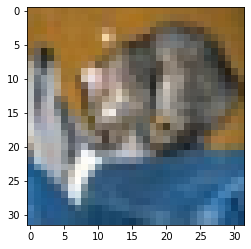

prediction: cat
true label: cat
(3, 32, 32)


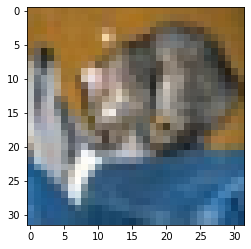

In [94]:
loader = iter(model.test_dataloader())
batch = loader.next()
predict(vgg16_3, batch)
predict(vgg, batch)

In [92]:
from PIL import Image, ImageOps

im = Image.open('plane.jpg')
im = im.convert('RGB')
im = im.resize((32, 32))
label = 0;

prediction: airplane
true label: airplane
(3, 32, 32)


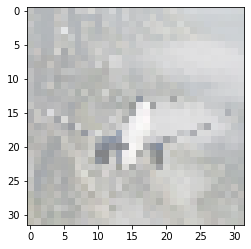

prediction: airplane
true label: airplane
(3, 32, 32)


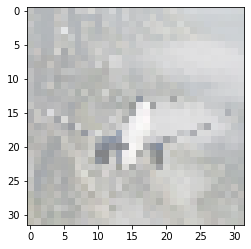

In [95]:
im_tensor = transforms.ToTensor()(im)
im_tensor = im_tensor.view((1,) + tuple(im_tensor.size()))
predict(vgg16_3, (im_tensor, label))
predict(vgg, (im_tensor, label))